In [1]:
from model import load_model, greedy_predict, tokens_to_text
from hooks import HookPoint, register_decoder_hook
from data import generate_dataset_pairs
import torch
import sympy

device = "cpu" # NOTE: change to cuda if your GPU can handle it

/home/carmen/miniconda3/envs/sensei/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/carmen/miniconda3/envs/sensei/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
model = load_model(device=device)

/home/carmen/miniconda3/envs/sensei/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/migration.py:208: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
Lightning automatically upgraded your loaded checkpoint from v1.3.3 to v2.5.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../res/100m.ckpt`


In [3]:
# If we uncomment the code below, we set all decoder MLP outputs to random values using interventions.
#  As you'll see below, the model won't be able to fit the correct equation (:omg:).

"""
def test_hook(output, _hook: HookPoint):
    return torch.randn_like(output)

for layer in range(4):
    register_decoder_hook(model.model, test_hook, HookPoint(layer, "mlp"))
"""

'\ndef test_hook(output, _hook: HookPoint):\n    return torch.randn_like(output)\n\nfor layer in range(4):\n    register_decoder_hook(model.model, test_hook, HookPoint(layer, "mlp"))\n'

In [4]:
complexity_dataset = generate_dataset_pairs("complexity-bias", 500, 10, model.model_cfg, model.eq_cfg, second_dataset_sample_rate=2)

X = complexity_dataset["X0"][0]
y = complexity_dataset["y0"][0]

print("Ground truth function")
sympy.sympify(complexity_dataset["equations"][0][0])

Ground truth function


x_2

In [5]:
# initial token prediction, this initializes the sequence and caches the encoder embedding (saves computation time).
tok, seq, enc_embed = greedy_predict(model.model, model.params_fit, X.unsqueeze(0), y.unsqueeze(0))

# repeatedly predict next token greedily
for i in range(30):
    seq = greedy_predict(model.model, model.params_fit, enc_embed=enc_embed, sequence=seq)[1]

# this should result in (roughly) the correct equation
print(seq)
greedy_pred = tokens_to_text(seq, model.params_fit)

print("Greedy predicted equation:")
for eq in greedy_pred:
    display(sympy.sympify(eq))

/home/carmen/miniconda3/envs/sensei/lib/python3.10/site-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


tensor([[ 1,  9,  5, 18,  4, 18,  5, 18,  6,  3,  2,  2,  2,  2,  2,  3,  2,  2,
          2,  2, 27,  2,  2,  2,  3,  2,  2,  2,  2,  2,  3,  2,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0]])
Greedy predicted equation:


c*x_1*x_2*x_3 + x_2

In [6]:
# fit model with beam search instead of greedy + constant fitting (takes a lot longer)
output = model.fitfunc(X, y)
# here you can see the fitted equations
output

Memory footprint of the encoder: 4.096e-05GB 



/home/carmen/master_ai/jaar_1/IAX/mini-project/SymbolicUnderstanding/src/nesymres/architectures/model.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X,device=self.device).unsqueeze(0)
/home/carmen/master_ai/jaar_1/IAX/mini-project/SymbolicUnderstanding/src/nesymres/architectures/model.py:140: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y,device=self.device).unsqueeze(0)


Constructing BFGS loss...
Flag idx remove ON, Removing indeces with high values...
checking input values range...
Loss constructed, starting new BFGS optmization...
Constructing BFGS loss...
Flag idx remove ON, Removing indeces with high values...
checking input values range...
Loss constructed, starting new BFGS optmization...


{'all_bfgs_preds': ['-4.39503947936825e-10*x_1*x_2*x_3 + x_2',
  '-5.46250022408643e-10*x_1*x_2/x_3 + x_2'],
 'all_bfgs_loss': [2.0008883e-14, 2.0918378e-14],
 'best_bfgs_preds': ['-4.39503947936825e-10*x_1*x_2*x_3 + x_2'],
 'best_bfgs_loss': [2.0008883e-14]}

In [7]:
print("Best BFGS prediction:")
sympy.sympify(output["best_bfgs_preds"][0])

Best BFGS prediction:


-4.39503947936825e-10*x_1*x_2*x_3 + x_2

In [19]:
from collections import defaultdict
from itertools import chain

def tokens_to_text_previous(tokens, params_fit):

    for batch in tokens:
        text = []
        for token in batch:

            if token.item() == 0 or token.item() == 2:
                break
            text.append(params_fit.id2word[token.item()])
    return text

# define hook to store intermediate representations (are overwritten after each auto-regressive step)
hooked_outputs = defaultdict()

def hook_intermediate_representations(output, _hook: HookPoint):
    """
    This hook function is used to extract intermediate representations from the model.
    It returns the output of the hooked component as a numpy array.
    """
    if _hook.component == "mlp":
        key = (_hook.component, _hook.layer)
    else:
        key = (_hook.component[0], _hook.component[1], _hook.layer)
    hooked_outputs[key] = output.detach().clone().cpu().numpy()
    return output

# register hooks for all decoder layers and components
for layer_idx in range(len(model.model.decoder_transfomer.layers)):
    register_decoder_hook(model.model, hook_intermediate_representations, HookPoint(layer_idx, "mlp"))
    for head_idx in range(model.model.decoder_transfomer.layers[layer_idx].multihead_attn.num_heads):

        register_decoder_hook(model.model, hook_intermediate_representations, HookPoint(layer_idx, ("self", head_idx)))
        register_decoder_hook(model.model, hook_intermediate_representations, HookPoint(layer_idx, ("cross", head_idx)))


def create_dataset(bias, num_eq):
    dataset_probing_train = generate_dataset_pairs(bias, 500, num_eq, model.model_cfg, model.eq_cfg, second_dataset_sample_rate=2)

    X_train_bias1 = dataset_probing_train["X0"]
    X_train_bias2 = dataset_probing_train["X1"]

    y_train_bias1 = dataset_probing_train["y0"]
    y_train_bias2 = dataset_probing_train["y1"]

    return X_train_bias1, X_train_bias2, y_train_bias1, y_train_bias2, dataset_probing_train



# run the model on the dataset and collect representations for training probe

def collect_representations(X, y, sign, label_id, states, labels):
    with torch.no_grad():

        for i in range(len(X)):
            print(i)
            tok, seq, enc_embed = greedy_predict(model.model, model.params_fit, X[i].unsqueeze(0), y[i].unsqueeze(0))

            # repeatedly predict next token greedily
            for _ in range(30):
                seq = greedy_predict(model.model, model.params_fit, enc_embed=enc_embed, sequence=seq)[1]
                formula_tokens = tokens_to_text_previous(seq, model.params_fit)
                if sign in "".join(formula_tokens):
                    labels.append(label_id)
                    for key, value in hooked_outputs.items():

                        if "mlp" in key[0]:
                            states[key].append(value)
                        else:
                            states[key].append(value[-1])
                    break
    return states, labels

# collect representations for plus and minus
train_split = 0.75
test_split = 1.0 - 0.75
num_eq = 80
states_train = defaultdict(list)
labels_train = []
X_plus, X_minus, y_plus, y_minus, _ = create_dataset("sign-bias", num_eq)
n_train_samples = int(num_eq * train_split)
collect_representations(X_plus[:n_train_samples], y_plus[:n_train_samples], "add", 1, states_train, labels_train)
collect_representations(X_minus[:n_train_samples], y_minus[:n_train_samples], "-", 0, states_train, labels_train)

# create test set
n_test_samples = int(num_eq * test_split)
states_test = defaultdict(list)
labels_test = []
collect_representations(X_plus[n_test_samples:], y_plus[n_test_samples:], "add", 1, states_test, labels_test)
collect_representations(X_minus[n_test_samples:], y_minus[n_test_samples:], "-", 0, states_test, labels_test)





('sin(cos(cos(x_1)))', 'x_1*x_2*x_1*x_2*x_2')


<lambdifygenerated-335>:2: RuntimeWarning: overflow encountered in exp
  return exp(abs(exp(x_3)))


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

probe_results = defaultdict()

for key, representation in states_train.items():
    print(f"Training probe for {key}...")

    X_train = torch.tensor(representation).squeeze(1)
    y_train = torch.tensor(labels_train)
    # train a logistic regression probe
    probe = LogisticRegression(solver="liblinear", penalty="l2", max_iter=10)

    probe.fit(X_train, y_train)

    # evaluate the probe
    X_test = torch.tensor(states_test[key]).squeeze(1)
    y_test = torch.tensor(labels_test)
    y_pred = probe.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {key}: {accuracy:.4f}")
    probe_results[key] = {
        "model": probe,
        "accuracy": accuracy
    }
# print the results
for key, result in probe_results.items():
    print(f"Probe for {key} achieved accuracy: {result['accuracy']:.4f}")


NameError: name 'states_train' is not defined

(5,)


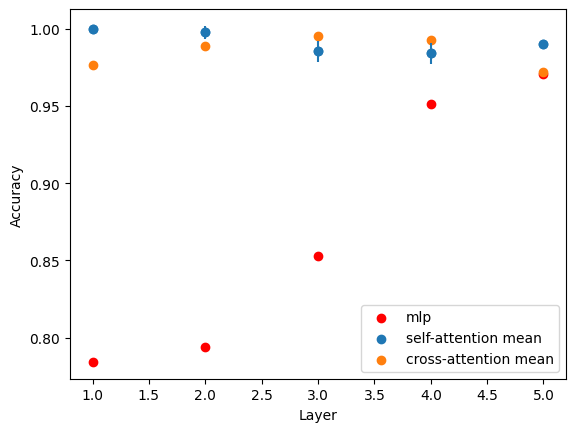

In [ ]:
# create plots
# heatmap with all the accuracies with x-axis the layers and y-axis the heads and for mlp just a strip
# line plot with one per attnetion head and the mlp so average the scores and show the standard deviation
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


matrix_mlp = np.zeros(5)
matrix_cross = np.zeros((len(model.model.decoder_transfomer.layers), len(range(model.model.decoder_transfomer.layers[0].multihead_attn.num_heads))))
matrix_self = np.zeros((len(model.model.decoder_transfomer.layers), len(range(model.model.decoder_transfomer.layers[0].multihead_attn.num_heads))))
for layer_idx in range(len(model.model.decoder_transfomer.layers)):
    matrix_mlp[layer_idx] = probe_results[('mlp', layer_idx)]['accuracy']

    for head_idx in range(model.model.decoder_transfomer.layers[layer_idx].multihead_attn.num_heads):

        matrix_cross[layer_idx, head_idx] = probe_results[('cross', head_idx, layer_idx)]['accuracy']
        matrix_self[layer_idx, head_idx] = probe_results[('self', head_idx, layer_idx)]['accuracy']

# sns.heatmap(matrix_self, annot=True)
# plt.title("self-attention accuracies")
# plt.xlabel("attention head")
# plt.ylabel("decoder layer")
# plt.show()
# plt.close()


# sns.heatmap(matrix_cross, annot=True)
# plt.title("cross-attention accuracies")
# plt.xlabel("attention head")
# plt.ylabel("decoder layer")
# plt.show()
# plt.close()

# print(matrix_mlp.shape)

aggregated_self_mean = np.mean(matrix_self, axis=1)
aggregated_self_std = np.std(matrix_self, axis=1)
aggregated_cross_mean = np.mean(matrix_cross, axis=1)
aggregated_cross_std = np.std(matrix_cross, axis=1)
print(aggregated_cross_std.shape)

plt.scatter([i for i in range(1, 6)], matrix_mlp, color='r', label="mlp")
plt.scatter([i for i in range(1, 6)], aggregated_self_mean, label="self-attention mean")
plt.scatter([i for i in range(1, 6)], aggregated_cross_mean, label="cross-attention mean")
plt.errorbar([i for i in range(1, 6)], aggregated_self_mean, yerr=aggregated_self_std, fmt='o')
plt.xlabel('Layer')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [11]:
complexity_dataset = generate_dataset_pairs("complexity-bias", 500, 10, model.model_cfg, model.eq_cfg, second_dataset_sample_rate=2)

X = complexity_dataset["X0"][0]
y = complexity_dataset["y0"][0]

print("Ground truth function")
sympy.sympify(complexity_dataset["equations"][0][0])

Ground truth function


0

In [ ]:
# initial token prediction, this initializes the sequence and caches the encoder embedding (saves computation time).
tok, seq, enc_embed = greedy_predict(model.model, model.params_fit, X.unsqueeze(0), y.unsqueeze(0))

# repeatedly predict next token greedily
for i in range(30):
    seq = greedy_predict(model.model, model.params_fit, enc_embed=enc_embed, sequence=seq)[1]

# this should result in (roughly) the correct equation
greedy_pred = tokens_to_text(seq, model.params_fit)

print("Greedy predicted equation:")
for eq in greedy_pred:
    display(sympy.sympify(eq))

/home/carmen/miniconda3/envs/sensei/lib/python3.10/site-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Greedy predicted equation:


0

In [13]:
# fit model with beam search instead of greedy + constant fitting (takes a lot longer)
output = fitfunc(X, y)

NameError: name 'fitfunc' is not defined

In [ ]:
# fit model with beam search instead of greedy + constant fitting (takes a lot longer)
output = model.fitfunc(X, y)
# here you can see the fitted equations
output

In [65]:
print("Best BFGS prediction:")
sympy.sympify(output["best_bfgs_preds"][0])

Best BFGS prediction:


x_1 + x_2*(x_1*x_3 + x_1)